In [4]:
import pandas as pd
import numpy as np
import os
import math
# from datetime import datetime,timedelta
import datetime
import matplotlib.pyplot as plt
import datetime
from PIL import Image
from scipy import interpolate
import matplotlib.backends.backend_pdf
from PyPDF2 import PdfFileMerger

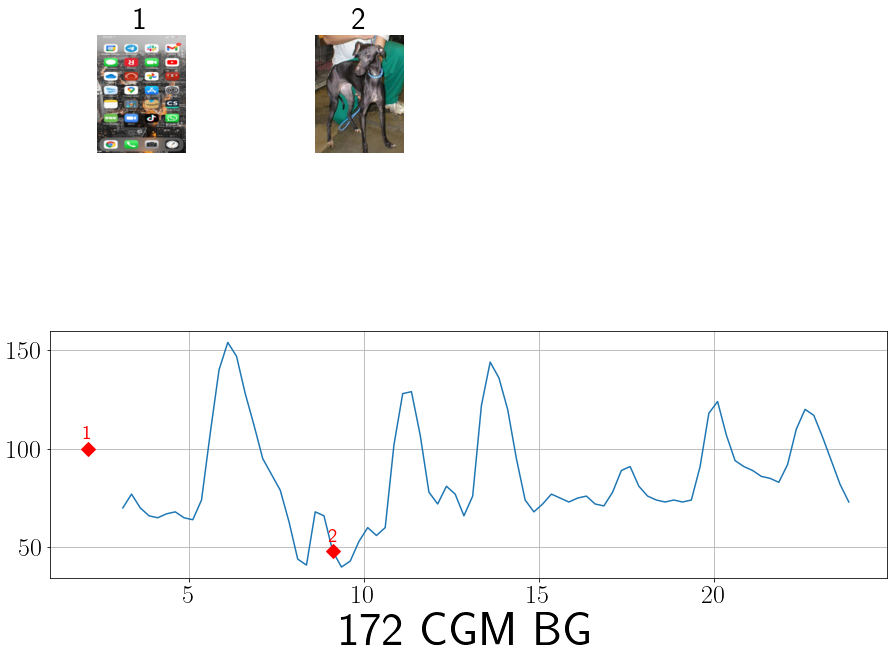

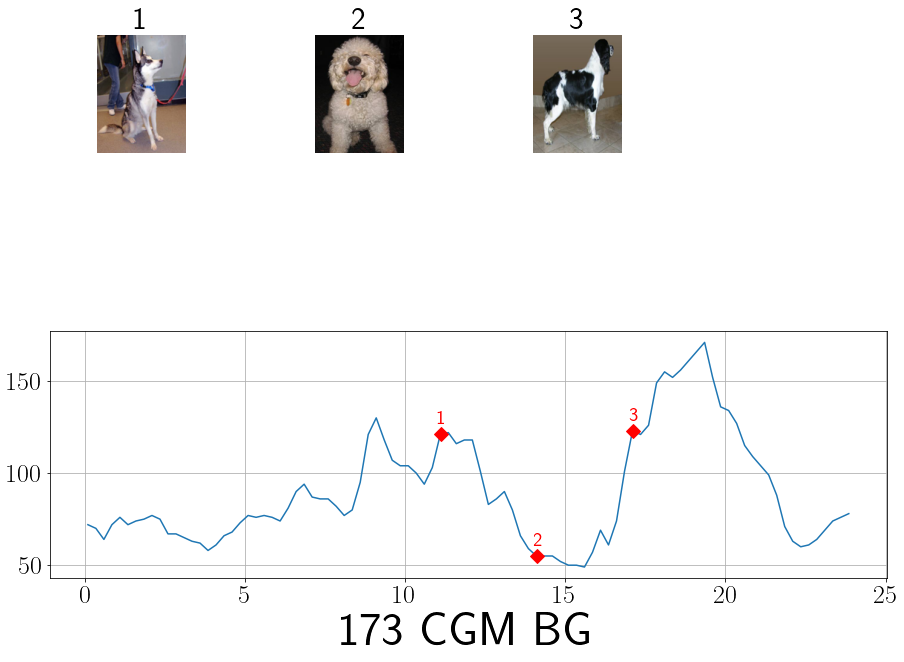

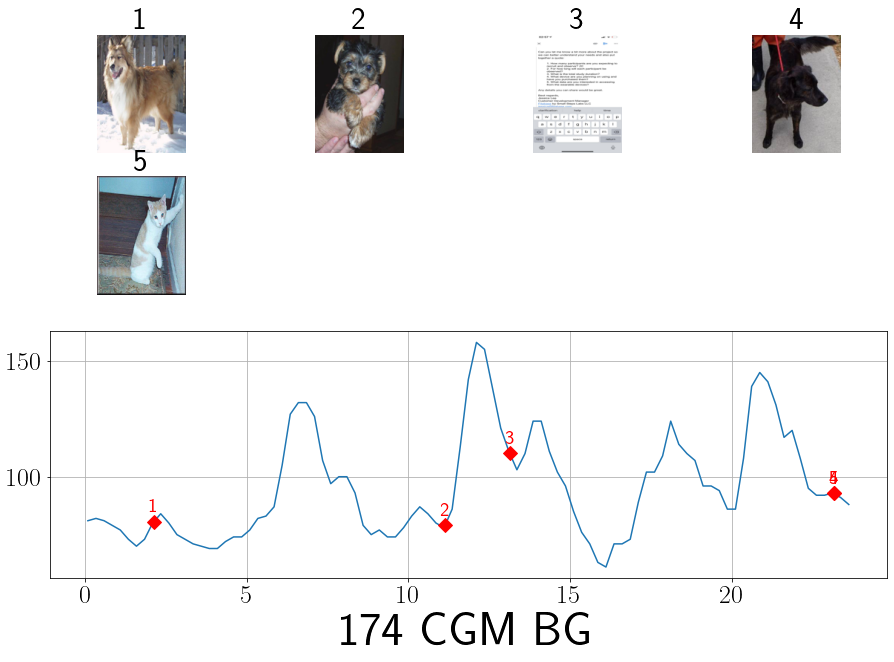

In [7]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size': 26})
plt.rc('text', usetex=True)

def movMeanFunc(pointNumber, variable):#Movmean on the CGM data or any other array to smooth it out
    assert variable.ndim==1
    startPoint=0
    endPoint=pointNumber
    movMeanVariable=np.empty((len(variable),1,))
    movMeanVariable[:] = np.nan
    while startPoint<len(variable):
        if(endPoint>=len(variable)):
            endPoint=len(variable)
        movMeanVariable[startPoint]=np.mean(variable[startPoint:endPoint])
        startPoint+=1
        endPoint+=1
    return movMeanVariable

def figPlotter(CGMTime, CGMData,day,):#Movmean on the CGM data or any other array to smooth it out
    currentFig=plt.figure(figsize=(15, 10))
    mealIndices = [i for i, x in enumerate(mealLogDayofYear) if x == day]
    mealCounter=0
    for mealCounter in range(0,len(mealIndices)):
        plt.subplot(4, 4, mealCounter+1)
        imageTemp=mealPhotos[mealIndices[mealCounter],:,:,:]
        imageTemp=imageTemp.astype(np.uint8)
        axs=plt.imshow(imageTemp)
        plt.title(str(mealCounter+1))
        plt.axis('off')
        
    plt.subplot(2, 1, 2)
    plt.plot(CGMTime,CGMData)
    for mealCounter in range(0,len(mealIndices)):
        pointLabels=str(mealCounter+1)        
        if(mealLogTime[mealIndices[mealCounter]]<=np.max(CGMTime) and mealLogTime[mealIndices[mealCounter]]>=np.min(CGMTime)):
            interpFunc=interpolate.interp1d(CGMTime, CGMData)
            interpRes=interpFunc(mealLogTime[mealIndices[mealCounter]])
            plt.plot(mealLogTime[mealIndices[mealCounter]],interpRes, 'D', color='red',markersize=10)
            plt.annotate(pointLabels,(mealLogTime[mealIndices[mealCounter]],interpRes),textcoords="offset points",xytext=(0,10),ha='center',size=20,color='red')
        else:
            plt.plot(mealLogTime[mealIndices[mealCounter]],100, 'D', color='red',markersize=10)
            plt.annotate(pointLabels,(mealLogTime[mealIndices[mealCounter]],100),textcoords="offset points",xytext=(0,10),ha='center',size=20,color='red')

    xlabelTemp=str(day)+' CGM BG'
    plt.xlabel('Time[hr]',fontsize=48)
    plt.xlabel(xlabelTemp,fontsize=48)
    plt.grid()
    
    pdfName=str(day)+"-CGMOutput.pdf"
    pdf = matplotlib.backends.backend_pdf.PdfPages(pdfName)
    pdf.savefig(currentFig)
    pdf.close()
    
    
def pdfMerger():
    myFiles=os.listdir()
    merger = PdfFileMerger()
    for myFile in myFiles:
        if"-CGMOutput.pdf" not in myFile:
            continue
        merger.append(myFile)
    merger.write("CGMOutput Total.pdf")
    merger.close()

#Reading the CGM data
CGMFileAddress=r'C:\GDrive\Documents\Educational\TAMU\Research\CGM-Data\cgm.csv'
CGMDataFrame=pd.read_csv(CGMFileAddress)
for myColumn in CGMDataFrame.columns: 
    if myColumn not in ['time','cgm']:
        del CGMDataFrame[myColumn]
CGMDataFrame=CGMDataFrame.dropna()
CGMDataFrame=CGMDataFrame.drop_duplicates(subset=['time'], keep='last')
CGMDataFrame['time']= pd.to_datetime(CGMDataFrame['time'])
CGMDataDayofYear=CGMDataFrame['time'].dt.dayofyear
CGMDataTime=CGMDataFrame['time'].dt.hour+(CGMDataFrame['time'].dt.minute)/60+(CGMDataFrame['time'].dt.second)/3600

CGMDataReading=CGMDataFrame['cgm'];
CGMDataReading=CGMDataReading.values;

#reading the meal photos from whatsApp export
mealFileDir=r'C:\GDrive\Documents\Educational\TAMU\Research\CGM-Data\meals'
imageHeight=120
imageWidth=160

os.chdir(mealFileDir)
myFiles=os.listdir()
imageNumber=len(myFiles)
mealPhotos=np.empty((imageNumber,imageWidth,imageHeight,3))
mealCounter=0
mealLogDayofYear=[]
mealLogTime=[]

for myFile in myFiles:
    if '.jpg' not in myFile:
        continue
    startIndex=myFile.index('PHOTO-')
    endIndex=myFile.index('.jpg')
    fileTimeStamp=myFile[startIndex+6:endIndex]
    fileTimeStamp = datetime.datetime.strptime(fileTimeStamp, '%Y-%m-%d-%H-%M-%S')
    TempDoY=fileTimeStamp.timetuple().tm_yday 
    TempHour=fileTimeStamp.hour+fileTimeStamp.minute/60+fileTimeStamp.second/3600
    mealLogDayofYear.append(TempDoY)
    mealLogTime.append(TempHour)

    imageTemp=Image.open(myFile)
    imageTemp = imageTemp.resize((imageHeight,imageWidth))
    imageTemp = np.asarray(imageTemp)
    mealPhotos[mealCounter,:,:,:]=imageTemp
    mealCounter+=1

recordCounter=0
startPoint=0
endPoint=0
dayNumber=len(np.unique(CGMDataDayofYear))
currentDay=CGMDataDayofYear[0]

for recordCounter in np.arange(0,len(CGMDataDayofYear)):
    if(currentDay!=CGMDataDayofYear[recordCounter]):
        endPoint=recordCounter
        figPlotter(CGMDataTime[startPoint:endPoint],CGMDataReading[startPoint:endPoint],currentDay)
        startPoint=recordCounter
    currentDay=CGMDataDayofYear[recordCounter]

endPoint=recordCounter
figPlotter(CGMDataTime[startPoint:endPoint],CGMDataReading[startPoint:endPoint],currentDay)
pdfMerger()